# Binary Classification with TF-IDF 

Adapted from:

https://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html#sphx-glr-auto-examples-model-selection-grid-search-text-feature-extraction-py

In [32]:
# Author: Olivier Grisel <olivier.grisel@ensta.org>
#         Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Mathieu Blondel <mathieu@mblondel.org>
# License: BSD 3 clause
from pprint import pprint
from time import time
import logging
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

Automatically created module for IPython interactive environment


In [33]:
# Dimension reduction and clustering libraries
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

In [34]:
CPA = pd.read_csv("../data/processed/CPA_tokenized.csv")
CPA.drop('Unnamed: 0', axis=1, inplace=True)
CPA.head()

,Order,Level,Code,Parent,Descr,tokens
0,1208792,1,A,NaN,"PRODUCTS OF AGRICULTURE, FORESTRY AND FISHING",PRODUCTS OF AGRICULTURE FORESTRY AND FISHING
1,1208793,2,01,A,"Products of agriculture, hunting and related s...",Products agriculture hunting related services
2,1208794,3,01.1,01,Non-perennial crops,Non-perennial crops
3,1208795,4,01.11,01.1,"Cereals , leguminous crops and oil seeds",Cereals leguminous crops oil seeds
4,1208796,5,01.11.1,01.11,Wheat,Wheat


In [35]:
# Create categories for Level 1 and Level 2 higherarchies
CPA2 = CPA.copy()
#get highest level of code
CPA2.loc[CPA2.Level !=1,'Category_2'] = CPA2[CPA2.Level !=1].Code.str.split('.').str.slice(0,1).str.join('')

# match up codes and parents
Code_parent = CPA2[CPA2.Level==2][['Parent','Category_2']].copy()
CPA2 = CPA2.merge(Code_parent.rename(columns={'Parent':'Category_1'}), on='Category_2', how='left')

# add in the Category_1 fileds for Level1
CPA2.loc[CPA2.Level==1, 'Category_1'] = CPA2.loc[CPA2.Level==1,'Code']

# we now set up a higher level for A10 indstry levels (10 categories)
update_dict0 = {'A':1,'F':3,'J':5, 'K':6, 'L':7,'M':8,'N':8}
update_dict = {**update_dict0,**dict.fromkeys(['B','C','D','E'],2),**dict.fromkeys(['G','H','I'],4),
               **dict.fromkeys(['O','P','Q'],9), **dict.fromkeys(['R','S','T','U'],10)}

CPA2['Category_0'] = CPA2.Category_1.replace(update_dict)
#CPA2 = CPA2.astype({'Category_0':int})
CPA2.head()

,Order,Level,Code,Parent,Descr,tokens,Category_2,Category_1,Category_0
0,1208792,1,A,NaN,"PRODUCTS OF AGRICULTURE, FORESTRY AND FISHING",PRODUCTS OF AGRICULTURE FORESTRY AND FISHING,NaN,A,1
1,1208793,2,01,A,"Products of agriculture, hunting and related s...",Products agriculture hunting related services,01,A,1
2,1208794,3,01.1,01,Non-perennial crops,Non-perennial crops,01,A,1
3,1208795,4,01.11,01.1,"Cereals , leguminous crops and oil seeds",Cereals leguminous crops oil seeds,01,A,1
4,1208796,5,01.11.1,01.11,Wheat,Wheat,01,A,1


In [36]:
# We now create an example based on Level 6 data
CPA_L6 = CPA2[CPA2.Level==6]
CPA_L6.head()

,Order,Level,Code,Parent,Descr,tokens,Category_2,Category_1,Category_0
5,1208797,6,01.11.11,01.11.1,Durum wheat,Durum wheat,01,A,1
6,1208798,6,01.11.12,01.11.1,Wheat,Wheat,01,A,1
8,1208800,6,01.11.20,01.11.2,Maize,Maize,01,A,1
10,1208802,6,01.11.31,01.11.3,Barley,Barley,01,A,1
11,1208803,6,01.11.32,01.11.3,Rye,Rye,01,A,1


## Notes on using TFIDF
CountVectorizer implements both tokenization and occurrence counting in a single class

In order to re-weight the count features into floating point values suitable for usage by a classifier it is very common to use the tf–idf transform.

As tf–idf is very often used for text features, there is also another class called TfidfVectorizer that combines all the options of CountVectorizer and TfidfTransformer in a single model

See also [scikit-learn on clustering](https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#sphx-glr-auto-examples-text-plot-document-clustering-py)

In [37]:
%pprint

Pretty printing has been turned OFF


In [38]:
tfidf_pipeline1 = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
])



In [39]:
tfidf_pipeline1.fit(CPA_L6.tokens)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer())])

# Simple visualisation - PCA

Adapted from

https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html#sphx-glr-auto-examples-decomposition-plot-pca-vs-lda-py

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.decomposition import PCA

X = tfidf_pipeline1.transform(CPA_L6.tokens).todense()
y = CPA_L6.Category_1
#target_names = ''

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

# plt.show()

In [41]:
df = CPA_L6.copy()
df['PCA_X'] = X_r[:,0]
df['PCA_Y'] = X_r[:,1]
df.head()

,Order,Level,Code,Parent,Descr,tokens,Category_2,Category_1,Category_0,PCA_X,PCA_Y
5,1208797,6,01.11.11,01.11.1,Durum wheat,Durum wheat,01,A,1,-0.025258,-0.060596
6,1208798,6,01.11.12,01.11.1,Wheat,Wheat,01,A,1,-0.025417,-0.061303
8,1208800,6,01.11.20,01.11.2,Maize,Maize,01,A,1,-0.025035,-0.059594
10,1208802,6,01.11.31,01.11.3,Barley,Barley,01,A,1,-0.024736,-0.058278
11,1208803,6,01.11.32,01.11.3,Rye,Rye,01,A,1,-0.024736,-0.058278


<AxesSubplot:xlabel='PCA_X', ylabel='PCA_Y'>

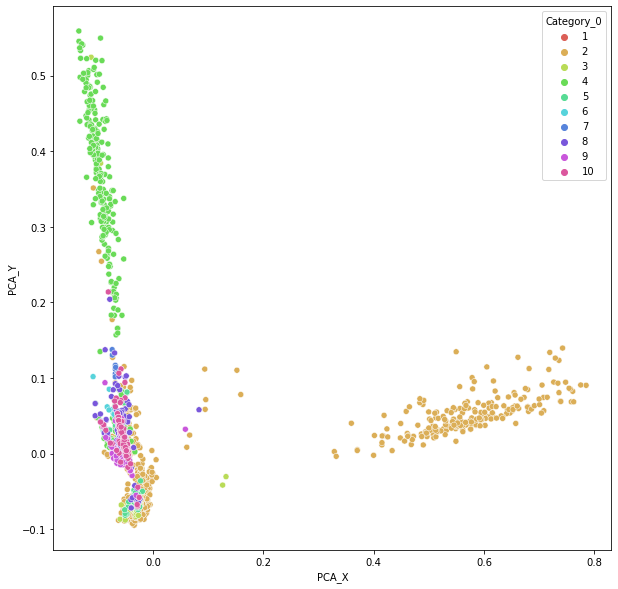

In [42]:
my_palette = sns.color_palette("hls", 10)
plt.figure(figsize=(10,10))
sns.scatterplot(data=df,x='PCA_X', y='PCA_Y', hue='Category_0', palette=my_palette)

# T-SNE visualisation

Adapted from: https://www.kaggle.com/premvardhan/amazon-fine-food-review-tsne-visualization

Not so good above 4 dimensions

In [43]:
from sklearn.manifold import TSNE


X = tfidf_pipeline1.transform(CPA_L6.tokens).todense()
y = CPA_L6.Category_1


pca = PCA(n_components=10)
X_r = pca.fit(X).transform(X)

model = TSNE(n_components=2, random_state=0, perplexity=50, n_iter=5000, verbose=10)

tsne_data = model.fit_transform(X_r)

tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2"))

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 3218 samples in 0.006s...
[t-SNE] Computed neighbors for 3218 samples in 0.336s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3218
[t-SNE] Computed conditional probabilities for sample 2000 / 3218
[t-SNE] Computed conditional probabilities for sample 3000 / 3218
[t-SNE] Computed conditional probabilities for sample 3218 / 3218
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.438s
[t-SNE] Iteration 50: error = 71.0373230, gradient norm = 0.0640935 (50 iterations in 1.460s)
[t-SNE] Iteration 100: error = 62.8502312, gradient norm = 0.0102782 (50 iterations in 0.952s)
[t-SNE] Iteration 150: error = 61.7814980, gradient norm = 0.0056973 (50 iterations in 0.947s)
[t-SNE] Iteration 200: error = 61.4070282, gradient norm = 0.0067781 (50 iterations in 1.223s)
[t-SNE] Iteration 250: error = 61.2216339, gradient norm = 0.0043304 (50 iterations in 0.945s)
[t-SNE] KL divergence after 250 iterat

In [46]:
df2 = CPA_L6.copy()
df2['dim1'] = tsne_data[:,0]
df2['dim2'] = tsne_data[:,1]
df2.head()

,Order,Level,Code,Parent,Descr,tokens,Category_2,Category_1,Category_0,dim1,dim2
5,1208797,6,01.11.11,01.11.1,Durum wheat,Durum wheat,01,A,1,-30.632713,8.883960
6,1208798,6,01.11.12,01.11.1,Wheat,Wheat,01,A,1,-31.046036,7.226515
8,1208800,6,01.11.20,01.11.2,Maize,Maize,01,A,1,-30.646881,12.107010
10,1208802,6,01.11.31,01.11.3,Barley,Barley,01,A,1,-28.966002,19.393576
11,1208803,6,01.11.32,01.11.3,Rye,Rye,01,A,1,-27.595137,21.196501


<AxesSubplot:xlabel='dim1', ylabel='dim2'>

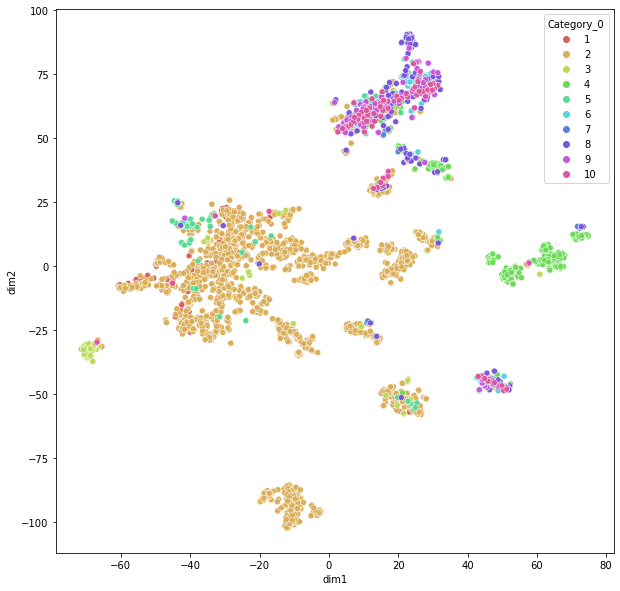

In [47]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=df2,x='dim1', y='dim2', hue='Category_0',  palette=my_palette)

# Binary Classification

We use the following:  

    - from sklearn.ensemble import RandomForestClassifier
    - from sklearn.model_selection import train_test_split
    - from sklearn.model_selection import cross_val_predict
    - from sklearn.metrics import roc_curve
    - from sklearn.metrics import roc_auc_score

[Taken from O'Reilly "Hands on Machine Learning" Chapter 3](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/ch03.html)

### First we split our data into a test set and a training set, randomly allocating categories

In [48]:
train_set, test_set = train_test_split(df2, test_size=0.2, random_state=42)
train_set.head()

,Order,Level,Code,Parent,Descr,tokens,Category_2,Category_1,Category_0,dim1,dim2
42,1208834,6,01.11.96,01.11.9,Castor oil seeds,Castor oil seeds,01,A,1,-49.779510,0.078164
4521,1213313,6,64.19.22,64.19.2,Consumer credit granting services by monetary ...,Consumer credit granting services monetary ins...,64,K,6,24.089575,60.788929
34,1208826,6,01.11.81,01.11.8,Soya beans,Soya beans,01,A,1,-31.989601,2.961392
2680,1211472,6,28.24.99,28.24.9,Sub-contracted operations as part of manufactu...,Sub-contracted operations part manufacturing p...,28,C,2,-10.083156,-89.697723
1707,1210499,6,23.12.11,23.12.1,"Glass in sheets, bent, edge-worked, engraved, ...",Glass sheets bent edge-worked engraved drilled...,23,C,2,-31.118729,-6.705379


## Now train a binary classifier - Random forest classifier
This will take each entry in Category_0 (1 to 10) in turn and apply train a binary classifier : this class vs all the others

We use the RandomForestClassifier with cros_val_predict 

In [49]:
def binary_cl(X_train, forest_clf, cat):
    y_train=(train_set.Category_0==cat)
    y_probas_forest = cross_val_predict(forest_clf, X_train, y_train, cv=3,  method="predict_proba")
    y_scores = cross_val_predict(forest_clf, X_train, y_train, cv=3, method='predict_proba')
    score = roc_auc_score(y_train, y_scores[:,1])
    return score
 
X_train = train_set[['dim1','dim2']]
forest_clf = RandomForestClassifier(random_state=42)



In [50]:
for cat in range (1,11):
    print(f'roc_auc score for {cat} is :', binary_cl(X_train, forest_clf, cat))



roc_auc score for 1 is : 0.8802101644595492
roc_auc score for 2 is : 0.9515766123135988
roc_auc score for 3 is : 0.9239886907351023
roc_auc score for 4 is : 0.9643777399496315
roc_auc score for 5 is : 0.8125590318772136
roc_auc score for 6 is : 0.8892343272579947
roc_auc score for 7 is : 0.8572228735183015
roc_auc score for 8 is : 0.8904300072766964
roc_auc score for 9 is : 0.8572683765796755
roc_auc score for 10 is : 0.8012784217070787


In [51]:
y_train_BE = (train_set.Category_0==2)
y_scores = cross_val_predict(forest_clf, X_train, y_train_BE, cv=3, method='predict_proba')
fpr, tpr, thresholds = roc_curve(y_train_BE, y_scores[:,1])

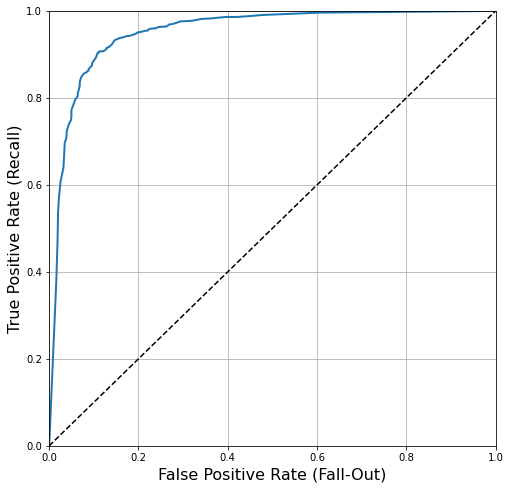

In [52]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 8))                         # Not shown
plot_roc_curve(fpr, tpr)

#save_fig("roc_curve_plot")                         # Not shown
plt.show()

# UMAP for Supervised Dimension Reduction and Metric Learning

https://umap-learn.readthedocs.io/en/latest/supervised.html

In [54]:
target = (train_set.Category_2)
embedding = umap.UMAP().fit_transform(X_train, y=target)

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


In [71]:
train_set.head()

,Order,Level,Code,Parent,Descr,tokens,Category_2,Category_1,Category_0,dim1,dim2
42,1208834,6,01.11.96,01.11.9,Castor oil seeds,Castor oil seeds,01,A,1,-49.779510,0.078164
4521,1213313,6,64.19.22,64.19.2,Consumer credit granting services by monetary ...,Consumer credit granting services monetary ins...,64,K,6,24.089575,60.788929
34,1208826,6,01.11.81,01.11.8,Soya beans,Soya beans,01,A,1,-31.989601,2.961392
2680,1211472,6,28.24.99,28.24.9,Sub-contracted operations as part of manufactu...,Sub-contracted operations part manufacturing p...,28,C,2,-10.083156,-89.697723
1707,1210499,6,23.12.11,23.12.1,"Glass in sheets, bent, edge-worked, engraved, ...",Glass sheets bent edge-worked engraved drilled...,23,C,2,-31.118729,-6.705379


In [72]:
df3 = train_set.copy()
df3['new1'] = embedding[:,0]
df3['new2'] = embedding[:,1]
df3.head()

,Order,Level,Code,Parent,Descr,tokens,Category_2,Category_1,Category_0,dim1,dim2,new1,new2
42,1208834,6,01.11.96,01.11.9,Castor oil seeds,Castor oil seeds,01,A,1,-49.779510,0.078164,-17.898991,2.341997
4521,1213313,6,64.19.22,64.19.2,Consumer credit granting services by monetary ...,Consumer credit granting services monetary ins...,64,K,6,24.089575,60.788929,-2.178589,11.357209
34,1208826,6,01.11.81,01.11.8,Soya beans,Soya beans,01,A,1,-31.989601,2.961392,-1.052589,-5.072258
2680,1211472,6,28.24.99,28.24.9,Sub-contracted operations as part of manufactu...,Sub-contracted operations part manufacturing p...,28,C,2,-10.083156,-89.697723,2.575947,-6.573665
1707,1210499,6,23.12.11,23.12.1,"Glass in sheets, bent, edge-worked, engraved, ...",Glass sheets bent edge-worked engraved drilled...,23,C,2,-31.118729,-6.705379,0.720936,-0.344982


<AxesSubplot:xlabel='new1', ylabel='new2'>

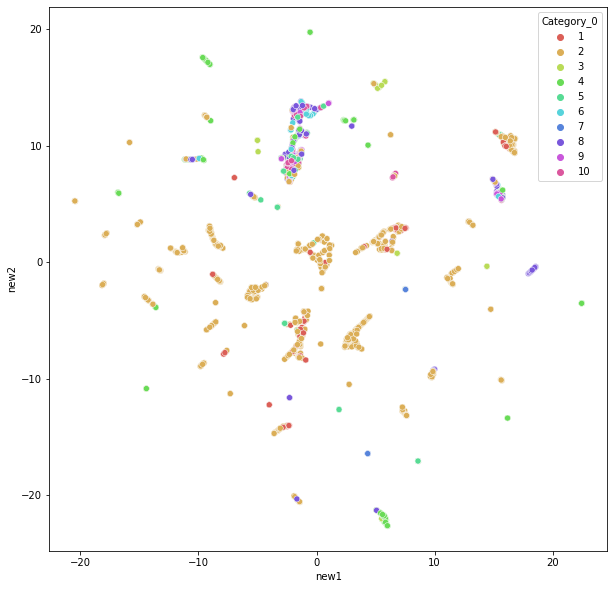

In [76]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=df3,x='new1', y='new2', hue='Category_0', palette=my_palette)

In [69]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=embedding ,x=embedding[:,0], y=embedding[:,1], hue='Category_2',  palette=my_palette)

/opt/conda/lib/python3.7/site-packages/seaborn/_core.py:876: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if val in data:


ValueError: Could not interpret value `Category_2` for parameter `hue`

<Figure size 720x720 with 0 Axes>

In [62]:
cats = [int(x) for x in train_set.Category_2.unique()]
cats

[1, 64, 28, 23, 10, 46, 11, 78, 21, 27, 13, 26, 17, 71, 85, 20, 38, 60, 81, 56, 87, 94, 72, 15, 25, 52, 47, 32, 7, 65, 16, 30, 33, 24, 49, 29, 58, 41, 69, 84, 51, 77, 3, 36, 8, 19, 55, 35, 50, 86, 22, 42, 79, 66, 68, 37, 61, 59, 53, 31, 14, 91, 74, 43, 88, 96, 98, 92, 73, 45, 95, 2, 93, 82, 70, 62, 99, 80, 18, 63, 5, 39, 6, 97, 12, 75, 90, 9]

AttributeError: 'PathCollection' object has no property 'hue'

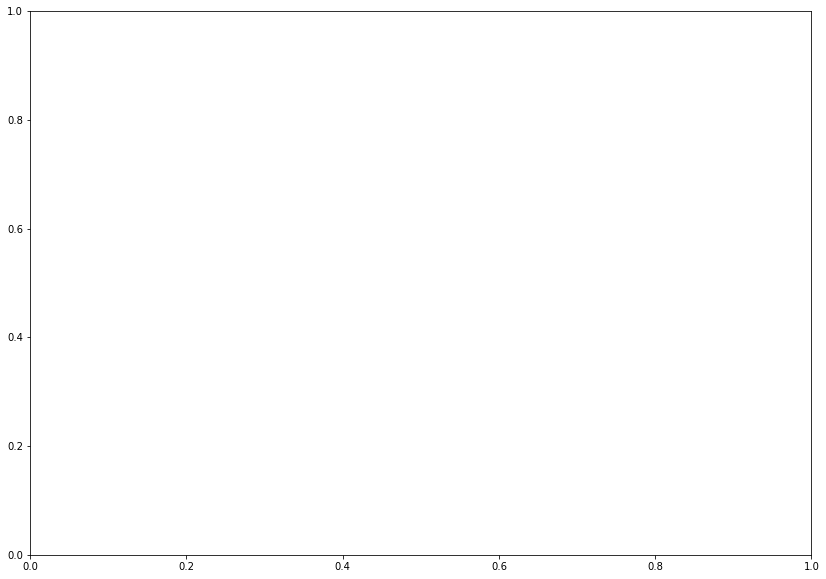

In [66]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*embedding.T, s=0.1, hue='Category_2',  cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
#cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
#cbar.set_ticks(np.arange(10))
#cbar.set_ticklabels(classes)
plt.title('CPA Embedded via UMAP using Labels');